# Fidus Data Cleaning

There are 3 tables exported from the Clinical Patient Management Software:

1. Patient data: Patnr, sex, date of birth
2. Surgery data: Patnr, date of surgery, lens model and refraction power, surgeon, comments, etc
3. Refraction data: patnr, date, refraction measures

The general Process is:
1. Clean each table
2. Validation tests
3. Remove unnecessary data
4. Merge tables into one
5. Compute further data e.g., age at surgery


In [2]:
# import libraries
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os


# Function to calculate age
def calculate_age(birthdate, refr_date):
    return relativedelta(refr_date, birthdate).years

In [3]:
# Define test patients
patnr_test = [1, 2, 100013, 189512, 738761, 979315]

# 1. Patient Data

In [4]:
# read csv file
patdat = pd.read_csv("data/FIDUS/patdat.csv", sep=";", encoding='ISO-8859-1')

Manipulations:
- rename and translate colum names
- remove empty columns
- change dtype of birthdate (datetime) and sex (boolean)

In [5]:
# drop empty column
patdat = patdat.drop(["Unnamed: 0"], axis=1)

# rename columns
patdat.rename(columns={"GEB" : "birthdate", "GES": "sex"}, inplace=True)

# remove test patients
patdat = patdat.loc[~patdat.patnr.isin(patnr_test)]

In [6]:
# delete wrong (missing) birthdates
patdat.loc[patdat.birthdate == "00:00:00", "birthdate"] = ""

# change dtype of datum
patdat.birthdate = pd.to_datetime(patdat.birthdate, dayfirst=True)

In [8]:
patdat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176798 entries, 0 to 176803
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   patnr      176798 non-null  int64         
 1   birthdate  176352 non-null  datetime64[ns]
 2   sex        176798 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 5.4 MB


# 2. Surgery Data

In [9]:
surg = pd.read_excel("data/FIDUS/ops.xlsx")

In [10]:
surg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34717 entries, 0 to 34716
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        0 non-null      float64       
 1   patnr             34717 non-null  int64         
 2   datum             34717 non-null  datetime64[ns]
 3   OP_Datum_R        17510 non-null  object        
 4   OP_Datum_R_count  34717 non-null  int64         
 5   OP_Datum_L        17267 non-null  object        
 6   OP_Datum_L_count  34717 non-null  int64         
 7   OP_Art_R          17663 non-null  object        
 8   OP_Art_R_count    34717 non-null  int64         
 9   OP_Art_L          17429 non-null  object        
 10  OP_Art_L_count    34717 non-null  int64         
 11  Linse_RA_R        16523 non-null  object        
 12  Linse_RA_L        16301 non-null  object        
 13  Operateur_R       17701 non-null  object        
 14  Operateur_L       1746

### Clean Data 

- remove test patients
- remove unneeded columns: empty and count columns
- remove occasions with more then one surgery per patient and day
- remove occasions without lens information (surgery without implantion)
- convert wide-to-long - use each eye as one datapoint
- remove for now occasions with unmatching dates: *surg_date* is a value from the surgery information, and *date* is an ID as part of the entity. n=69. UPDATE: After validation, I used date as the the more reliable column

In [11]:
# drop empty column
surg = surg.drop(["Unnamed: 0"], axis=1)

# remove test patients
surg = surg.loc[~surg.patnr.isin(patnr_test)]

In [13]:
# occasions with > 1 surgery per patient and day: 11R + 7L
surg.loc[(surg.OP_Datum_R_count > 1) | (surg.OP_Datum_L_count > 1)]

# remove those
surg = surg.loc[~((surg.OP_Datum_R_count > 1) | (surg.OP_Datum_L_count > 1))]

# remove count columns
surg = surg.drop(["OP_Datum_R_count", "OP_Datum_L_count", "OP_Art_R_count", "OP_Art_L_count"], axis=1)

In [15]:
# combine R and L side by melting from wide to long format  -> 69400 rows
surg_long = pd.wide_to_long(
    surg,
    stubnames=[
        "OP_Datum",
        "OP_Art",
        "Linse_RA",
        "Operateur",
        "OP_Bericht",
        "OP_Bemerkung",
    ],
    i=["patnr", "datum"],
    j="side",
    suffix="[RL]",
    sep="_",
).reset_index()

# delete all rows with no lens information. This includes NA-entries from the previous mode of storage (only one eye-surgery per date) AND surgeries without implants -> 32810 rows
surg_long = surg_long.dropna(subset = ["Linse_RA"])

# change column names to english
surg_long = surg_long.rename(columns={"datum":"date", "OP_Datum":"surg_date", "OP_Art": "procedure", "Linse_RA": "lens", "Operateur": "surgeon", "OP_Bericht": "surg_note_1", "OP_Bemerkung":"surg_note_2"})

# change dtype of surg_date
surg_long["surg_date"] = pd.to_datetime(surg_long.surg_date, dayfirst=True)

In [ ]:
# test if surg_date = date (should be)
surg_long.loc[surg_long.date != surg_long.surg_date].drop(["surgeon", "surg_note_1", "surg_note_2"], axis=1)

In [17]:
# remove those lines for now (n=69)
#surg_long = surg_long.loc[surg_long.date == surg_long.surg_date]

# after following uo on these cases, "date" is the always correct date 
surg_long = surg_long.drop("surg_date", axis=1).rename(columns={"date":"surg_date"})

In [18]:
surg_long.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32798 entries, 1 to 69314
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   patnr        32798 non-null  int64         
 1   surg_date    32798 non-null  datetime64[ns]
 2   side         32798 non-null  object        
 3   procedure    32789 non-null  object        
 4   lens         32798 non-null  object        
 5   surgeon      32797 non-null  object        
 6   surg_note_1  7257 non-null   object        
 7   surg_note_2  13029 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 2.3+ MB


### Implant Surgeries per Day  

In [19]:
surg_long.groupby("surg_date").count().mean()

patnr          18.752430
side           18.752430
procedure      18.747284
lens           18.752430
surgeon        18.751858
surg_note_1     4.149228
surg_note_2     7.449400
dtype: float64

### Select Surgical Procedure Types

Type of surgeries - clinical decision on what to include

Include:
- pimäre Implantation einer
- einer Monofokal-, torischen oder EDOF-Linse 
- durch Phakoemulsifikation oder Phemto-laser 
- in den Kapselsack

Exclude
- sekundäre OPs
- Linsen: Multifokal, verisyse (nicht im Kapselsack)
- Femto-Laser zur Astigmatismusreduktion

In [20]:
included_surgeries = ["Phakoemulsifikation in Tropfanästhesie mit Implantation einer Monofokallinse",
                      "femtolaserassistierte Kataraktchirurgie (FLACS) in Tropfanästhesie mit Implantation einer Monofokallinse",
                      "Phakoemulsifikation in Tropfanästhesie mit Implantation einer torischen Intraokularlinse",
                      "femtolaserassistierte Kataraktchirurgie (FLACS) in Tropfanästhesie mit Implantation einer torischen Intraokularlinse"
                      "femtolaserassistierte Kataraktchirurgie (FLACS)  in Tropfanästhesie mit Implantation einer torischen Intraokularlinse",
                      "femtolaserassistierte Kataraktchirurgie (FLACS) in Tropfanästhesie mit Implantation einer Monofokallinse",
                      "femtolaserassistierte Kataraktchirurgie (FLACS)  in Tropfanästhesie mit Implantation einer Monofokallinse mit erweitertem Intermediärbereich",
                      #"femtolaserassistierte Kataraktchirurgie (FLACS) mit Astigmatismusausgleich in Tropfanästhesie mit Implantation einer Monofokallinse",
                      "femtolaserassistierte Kataraktchirurgie (FLACS)  in Tropfanästhesie mit Implantation einer torischen Monofokallinse mit erweitertem Intermediärbereich",
                      "Phakoemulsifikation in Tropfänesthesie mit Implantation einer Monofokallinse mit erweitertem Intermediärbereich",
                      "femtolaserassistierte Kataraktchirurgie (FLACS)  in Tropfanästhesie mit Implantation einer torischen Intraokularlinse mit erweitertem Intermediärbereich",
                      "Phakoemulsifikation in Tropfanästhesie mit Implantation einer torischen Monofokallinse",
                      "Phakoemulsifikation in Tropfanästhesie mit Implantation einer Monofokallinse mit erweitertem Intermediärbereich",
                      "Phakoemulsifikation in Tropfanästhesie mit Implantation einer torischen Intraokularlinse mit erweitertem Intermediärbereich",
                      "Phakoemulsifikation in Tropfänesthesie mit Implantation einer torischen Monofokallinse mit erweitertem Intermediärbereich",
                      "femtolaserassistierte Kataraktchirurgie (FLACS)  in Tropfanästhesie mit Implantation einer Monofokallinse (AI)",
                      "femtolaserassistierte Kataraktchirurgie (FLACS)  in Tropfanästhesie mit Implantation einer torischen Monofokallinse mit erweiterten intermediären Bereich",
                      "Phakoemulsifikation in Tropfänesthesie mit Implantation einer Monofokallinse mit erweitertem intermediärem Bereich",
                      "femtolaserassistierte Kataraktchirurgie (FLACS)  in Tropfanästhesie mit Implantation einer torischen Monofokallinse",
                      "femtolaserassistierte Kataraktchirurgie (FLACS) in Tropfanästhesie mit Implantation einer torischen Intraokularlinse mit erweitertem Intermediärbereich",
                      "femtolaserassistierte Kataraktchirurgie (FLACS)  in Tropfanästhesie mit Implantation einer Intraokularlinse mit erweitertem Intermediärbereich",
                      "Phakoemulsifikation in Tropfanästhesie mit Implantation einer torischen Monofokallinse mit erweitertem Intermediärbereich",
                      "femtolaserassistierte Kataraktchirurgie (FLACS)  in Tropfanästhesie mit Implantation einer torischen IOL",
                      "Phakoemulsifikation in Tropfanästhesie mit Implantation einer Intraokularlinse mit erweitertem Intermediärbereich",
                      "Phakoemulsifikation in Tropfänesthesie mit Implantation einer torischen Intraokularlinse mit erweitertem Intermediärbereich",
                      "Phakoemulsifikation in Tropfanästhesie mit Implantation einer torischen Monofokallinse mit erweiterten intermediären Bereich",
                      "femtolaserassistierte Kataraktchirurgie (FLACS)  in Tropfanästhesie mit Implantation einer Monofokallinse mit erweitertem intermediärem Bereich",
                      "femtolaserassistierte Kataraktchirurgie (FLACS)  in Tropfanästhesie mit Implantation einer Monofokallinse mit erweiterten intermediären Bereich",
                      "FLACS in Tropfanästhesie mit Implantation einer Monofokallinse",
                      "Phakoemulsifikation in Tropfanästhesie mit Implantation einer torischen Intraokularlinse mit erweitertem intermediärem Bereich",
                      "Phakoemulsifikation in Tropfanästhesie mit Implantation einer Monofokallinse mit erweiterten intermediären Bereich",
                      "femtolaserassistierte Kataraktchirurgie (FLACS)  in Tropfanästhesie mit Implantation einer torischen Intraokularlinse mit erweitertem intermediärem Bereich",
                      "femtolaserassistierte Kataraktchirurgie (FLACS)  in Tropfanästhesie mit Implantation einer Monofokallinse mit Astigmatismusausgleich",
                      "Phakoemulsifikation in Tropfanästhesie mit Implantation einer torischen Intraokularlinse mit erweiterten Intermediärbereich",
                      "Phakoemulsifikation in Tropfanästhesie mit Implantation einer torischen IOL"
                      
                      ]

In [21]:
pd.reset_option("display.max_colwidth", None)
pd.reset_option("display.max_rows", None)
x = pd.DataFrame(surg_long.procedure.value_counts()).reset_index()#.to_csv("data/temp_procedure_count.csv", index=False)
x

,procedure,count
0,Phakoemulsifikation in Tropfanästhesie mit Imp...,21857
1,femtolaserassistierte Kataraktchirurgie (FLACS...,2262
2,Phakoemulsifikation in Tropfanästhesie mit Imp...,1536
3,femtolaserassistierte Kataraktchirurgie (FLACS...,605
4,Explantation einer kalzifizierten IOL mit Impl...,420
...,...,...
821,femtolaserassierter refraktiver Linsenaustausc...,1
822,femtolaserassistierte Kataraktchirurgie (FLACS...,1
823,femtolaserassistierte Kataraktchirurgie in Tro...,1
824,femtolaserasistierter refraktiver Linsenaustau...,1


In [22]:
# remove excluded surgery types
surg_long = surg_long.loc[surg_long["procedure"].isin(included_surgeries)]

### Select surgeon

only look at data from one surgeon.

In [ ]:
# find the surgeons
surgeon = "surgeonname"
pd.DataFrame(surg_long.surgeon.value_counts()).reset_index().assign(
    str_find=lambda x: x.surgeon.str.contains(surgeon, case=False)
)

In [ ]:
# keep only those surgeries performed by this surgeon. Drop surgeon column
surg_long = (
    surg_long.loc[surg_long.surgeon.str.contains(surgeon, case=False) == True]
    .drop(["surgeon"], axis=1)
)

surg_long

### Multiple Surgery-patients


In [25]:
# find patients with more than 2 implant surgeries 
id_count = pd.DataFrame(surg_long.patnr.value_counts()).reset_index()
id_sel = id_count.loc[id_count["count"] > 2, "patnr"]

# Nr of patients:
len(id_sel)

3

In [ ]:
# List those cases
with pd.option_context("display.max_colwidth", None):
    display(
        surg_long.loc[surg_long.patnr.isin(id_sel)]
        .drop(["surg_note_1", "surg_note_2"], axis=1)
        .sort_values(["patnr", "surg_date"])
        #.to_csv("data/temp_multiple_proc.csv", index=False)
    )

# in these 3 cases the implanted lens was the same.
# but the output ignores the possiblity of a patient having two surgeries on one eye but not the other..

In [ ]:
# find patients with more then 1 surgery on one eye 
x = (surg_long.groupby(["patnr", "side"]).count()>1).max(axis=1).reset_index()
ids_plus1_surgery_per_eye = x.loc[x[0] == 1, ["patnr", "side"]]
ids_plus1_surgery_per_eye

In [28]:
# merge with surg_long on both identifiers, patnr and side, to remove those cases
temp_merge = surg_long.merge(ids_plus1_surgery_per_eye, "left", on=["patnr", "side"], indicator=True)
surg_long = temp_merge[temp_merge._merge == "left_only"]
surg_long = surg_long.drop(["_merge"], axis=1)

the table now contains one surgery per eye

### Extract Lens Information

In [29]:
# define new boolean column "torisch"
surg_long['torisch'] = surg_long['lens'].str.contains('cyl', case=False, na=False)

# extract astigmatism refraction value
def extract_decimal_after_cyl(text):
    # Search for a pattern where 'cyl' is followed by any non-digit characters (including spaces and symbols)
    # and then captures the following digits which might include a comma or point as decimal separator
    match = re.search(r'cyl[^0-9]*([\d,\.]+)', text, re.IGNORECASE)
    if match:
        # Replace comma with dot if found and return the number
        return (match.group(1).replace(',', '.'))
    return None

# Create the 'torisch_dpt' column using the function
surg_long['IOL_torisch_dpt'] = surg_long['lens'].apply(extract_decimal_after_cyl)

# remove single point in some cases
surg_long.loc[surg_long['IOL_torisch_dpt'] == ".", "IOL_torisch_dpt"] = ""

# convert to float
surg_long['IOL_torisch_dpt'] = pd.to_numeric(surg_long['IOL_torisch_dpt'])


# Function to extract the main dpt value - the first number which includes a decimal comma
def extract_first_number(text):
    # Regular expression to find the first occurrence of a number with a decimal comma
    match = re.search(r'-?\s*\d+[,.]\d+', text)
    if match:
        # Replace comma with dot for decimal places and convert to float
        return float(match.group().replace(',', '.').replace(' ', ''))

# run the function
surg_long['IOL_dpt'] = surg_long['lens'].apply(extract_first_number)


# a new variable lens_series, that only contains the lens series
def remove_dpt(text):
    return re.sub(r'[+-]?\s*\d+[,.]\d+.*$', '', text)

# Apply the function to create a new column that removes text before the number
surg_long['lens_series'] = surg_long['lens'].apply(remove_dpt)

# remove all . and , and strips empty spaces
surg_long['lens_series'] = surg_long['lens_series'].str.replace('[.,]', '', regex=True).str.strip()


In [30]:
# find weird cases
surg_long.loc[surg_long.lens.str.contains("\-"), ["lens", "torisch", "IOL_torisch_dpt", "IOL_dpt", "lens_series"]].sample(30)

,lens,torisch,IOL_torisch_dpt,IOL_dpt,lens_series
21976,"Teleon LS-313 T4 17,0 Cyl. 3,75",True,3.75,17.0,Teleon LS-313 T4
18378,Oculentis LS-313 T1 21.0 cyl 1.5,True,1.50,21.0,Oculentis LS-313 T1
17726,"Domilens AS66-Y 24,5",False,NaN,24.5,Domilens AS66-Y
18933,"Oculentis LS-313 MF15 20,5",False,NaN,20.5,Oculentis LS-313 MF15
5237,"Domilens AS66-Y 21,5",False,NaN,21.5,Domilens AS66-Y
20934,Teleon L-313 22.5,False,NaN,22.5,Teleon L-313
5762,"Domilens AS66-Y 24,0",False,NaN,24.0,Domilens AS66-Y
684,"Domilens AS66-Y 13,0",False,NaN,13.0,Domilens AS66-Y
6896,"Domilens AS66-Y 19,0",False,NaN,19.0,Domilens AS66-Y
10093,"Laserlens LB-313 G 23,5",False,NaN,23.5,Laserlens LB-313 G


In [31]:
surg_long[["lens", "torisch", "IOL_torisch_dpt", "IOL_dpt", "lens_series"]].sample(30)

,lens,torisch,IOL_torisch_dpt,IOL_dpt,lens_series
9520,"1stQ 690 ABY 19,0",False,NaN,19.0,1stQ 690 ABY
21657,"Zeiss AT Torbi 709 M 21,0 cyl 2,0",True,2.0,21.0,Zeiss AT Torbi 709 M
6105,"Oculentis LS-313 T3 12,5 cyl 3,0",True,3.0,12.5,Oculentis LS-313 T3
12796,"1stQ 690 ABY 26,5",False,NaN,26.5,1stQ 690 ABY
6217,"Domilens 677 ABY 20,5",False,NaN,20.5,Domilens 677 ABY
11857,"1stQ 690 ABY 28,0",False,NaN,28.0,1stQ 690 ABY
9559,"Domilens 677 ABY 21,5",False,NaN,21.5,Domilens 677 ABY
4311,"Domilens 677 ABY 25,0",False,NaN,25.0,Domilens 677 ABY
4834,"Zeiss AT Torbi 709 M 2,0 Cyl. 2.0",True,2.0,2.0,Zeiss AT Torbi 709 M
23101,"Teleon Acunex AN6V 19,5 cyl 1,50",True,1.5,19.5,Teleon Acunex AN6V


In [ ]:
surg_long

---

# 3. Refraction Data

In [33]:
# detect csv encoding type
import chardet

# Detect the character encoding of the CSV file
with open("data/FIDUS/refra.csv", 'rb') as file:
    print(chardet.detect(file.read()))  # or file.read(10000) to read just the first 10000 bytes

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


In [34]:
# read csv file
refr = pd.read_csv("data/FIDUS/refra.csv", sep=";", encoding='ISO-8859-1')

C:\Users\nix-n\AppData\Local\Temp\ipykernel_24636\1336586817.py:2: DtypeWarning: Columns (4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  refr = pd.read_csv("data/FIDUS/refra.csv", sep=";", encoding='ISO-8859-1')


In [35]:
refr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692874 entries, 0 to 692873
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  0 non-null       float64
 1   PATNR       692874 non-null  int64  
 2   MESSDATUM   692874 non-null  object 
 3   NR          7576 non-null    float64
 4   RSPHAERE    627082 non-null  object 
 5   RZYLINDER   580026 non-null  object 
 6   RACHSE      579994 non-null  object 
 7   LSPHAERE    626001 non-null  object 
 8   LZYLINDER   577618 non-null  object 
 9   LACHSE      577586 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 52.9+ MB


### First Manipulations
- delete empty columns "Unnamed: 0" and additional columns "X" - content not relevant, only 4 entries
- dtype date
- assign side and get rid of attribute name "OReAVR:"
- translate column names to english

In [37]:
# drop unneeded columns
refr = refr.drop(["Unnamed: 0", "NR"], axis=1)

# rename columns
refr.rename(columns={"PATNR" : "patnr", "MESSDATUM":"refr_date", "RSPHAERE": "sphere_R", "RZYLINDER":"cyl_R", "RACHSE":"ax_R", "LSPHAERE": "sphere_L", "LZYLINDER":"cyl_L", "LACHSE":"ax_L"}, inplace=True)

# remove test patients
refr = refr.loc[~refr.patnr.isin(patnr_test)]

# change dtype of datum
refr["refr_date"] = pd.to_datetime(refr["refr_date"], dayfirst=True)

# check for and remove duplicates
refr.duplicated().sum() # -> 71
refr.drop_duplicates(inplace=True)

### Statistics: Age at first Refra

In [ ]:
# Age at first measurement of each patient
refr_ages_grouped = refr[["patnr", "refr_date"]].groupby(["patnr"]).first().reset_index().merge(patdat, "left", "patnr").dropna(subset=["birthdate"])
refr_ages_grouped["age_at_first_refr"] = refr_ages_grouped.apply(lambda row: calculate_age(row["birthdate"], row["refr_date"]), axis=1)

# Add age at last measurement of each patient
refr_ages_grouped2 = refr[["patnr", "refr_date"]].groupby(["patnr"]).last().reset_index().merge(patdat, "left", "patnr").dropna(subset=["birthdate"])
refr_ages_grouped2["age_at_last_refr"] = refr_ages_grouped2.apply(lambda row: calculate_age(row["birthdate"], row["refr_date"]), axis=1)
refr_ages_grouped = pd.merge(refr_ages_grouped,refr_ages_grouped2[["patnr", "age_at_last_refr"]], "left", "patnr")

refr_ages_grouped

In [40]:
refr_ages_grouped.age_at_first_refr.describe()
refr_ages_grouped.age_at_last_refr.describe()

count    132357.000000
mean         51.772358
std          25.266383
min          -8.000000
25%          32.000000
50%          55.000000
75%          74.000000
max         102.000000
Name: age_at_last_refr, dtype: float64

there are some patients with negative ages..?

In [ ]:
refr_ages_grouped.loc[refr_ages_grouped.age_at_first_refr<0]

<Axes: >

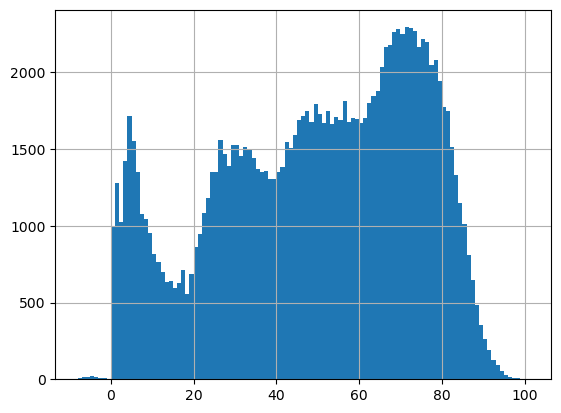

In [44]:
refr_ages_grouped.age_at_first_refr.hist(bins=109)

<Axes: >

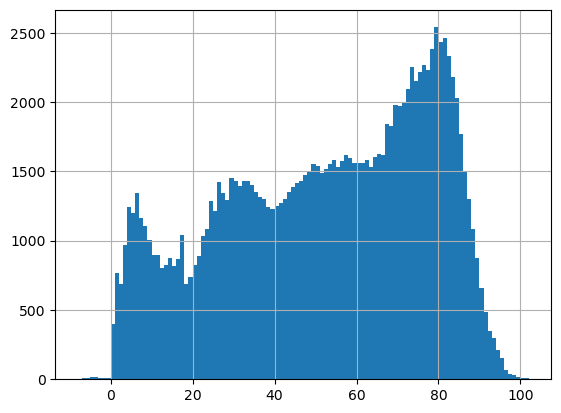

In [45]:
refr_ages_grouped.age_at_last_refr.hist(bins=110)

### Multiple refraction measurements per day and patient
are there several measurements per patient and date? 

In [46]:
# several measures per patient and date
refr_count = refr.groupby(["patnr", "refr_date"]).count()
refr_count_3plus = refr_count.loc[(refr_count>2).sum(axis=1) != 0].reset_index()
refr_count_2plus = refr_count.loc[(refr_count>1).sum(axis=1) != 0].reset_index()
refr_count_2plus_age = refr_count_2plus.merge(patdat, "left", "patnr")

# drop NA <- 1 row
refr_count_2plus_age.dropna(subset=["birthdate"], inplace=True)

# Compute age at time of measurement 
refr_count_2plus_age["age_at_refr"] = refr_count_2plus_age.apply(
    lambda row: calculate_age(row["birthdate"], row["refr_date"]), axis=1
)

yes, 4500 to 6500 pairs are equal ->
- get statistics on those with 2 measurements-> very different values? maybe just take the AVG?
- remove those with more then 2 measurements (~115-180)

<Axes: >

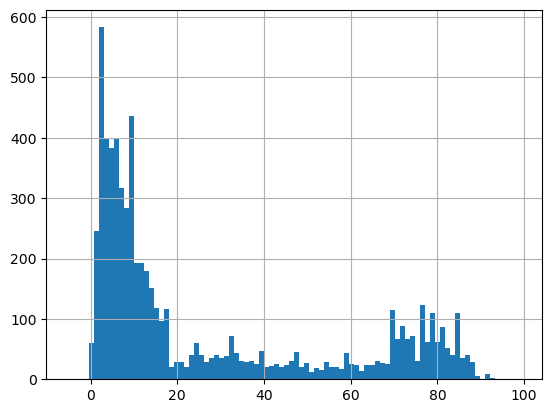

In [48]:
refr_count_2plus_age.age_at_refr.hist(bins=90) # -> most of the patients with multiple refracts measurements seems to be children (as seen in FIDUS). 

In [ ]:
# How many adults? -> ~ 2500  can I disregard those are find another way to deal with the data?
refr_count_2plus_age.loc[refr_count_2plus_age.age_at_refr >= 18].sample(30)

results
- many 2 and 3-measure datapoints are children <- those are excluded anyway
- still around 2500 adults. we tested one: measured with and without contact lens. sadly, i dont have the commentary field of the measurements, thus I cant automatize the decision of what to do with those cases 

-> for now, remove all those from the dataset

In [50]:
# Merge refr with refr_count_2plus_age to get the indicator
merged = pd.merge(refr, refr_count_2plus[['patnr', 'refr_date']], on=['patnr', 'refr_date'], 
                  how='left', indicator=True)

# Filter rows to find those only in the left DataFrame (original `refr`)
refr_ = merged[merged['_merge'] == 'left_only']

# remove indicator column
refr_ = refr_.drop(columns=['_merge'])

# these reamaning duplicates on id/day are seperate left/right measurements. I can merge those and keep them
refr_leftright_sep = refr_.loc[refr_.duplicated(subset=['patnr', 'refr_date'], keep=False)]
refr_leftright_sep_merge = refr_leftright_sep.groupby(["patnr", "refr_date"]).first().reset_index()
refr_leftright_sep_merge

# remove all duplicates and add merged duplicates (n=78)
refr_ = refr_.drop_duplicates(subset=['patnr', 'refr_date'], keep=False)
refr_ = pd.concat([refr_, refr_leftright_sep_merge], axis=0)

# How many datapoints were removed?
print(f"Nr of measurements: {refr.patnr.count()} \nNr of measurements after exclusion: {refr_.patnr.count()}  \nNr of removed measurements: {refr.patnr.count()-refr_.patnr.count()}")

Nr of measurements: 692672 
Nr of measurements after exclusion: 679087  
Nr of removed measurements: 13585


In [ ]:
refr_

### Convert wide-to-long

In [52]:
# convert to long format
refr_long = pd.wide_to_long(
    refr_,
    stubnames=[
        "sphere",
        "cyl",
        "ax"
    ],
    i=["patnr", "refr_date"],
    j="side",
    suffix="[RL]",
    sep="_",
).reset_index()

### Clean measurements

- in sphere: remove "+", keep "-"
- remove other symbols 
- change "," to "."
- remove anythying before that first (negative) digit and behind the last digit 
- convert all to INT 

In [54]:
refr_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1358174 entries, 0 to 1358173
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   patnr      1358174 non-null  int64         
 1   refr_date  1358174 non-null  datetime64[ns]
 2   side       1358174 non-null  object        
 3   sphere     1226307 non-null  object        
 4   cyl        1135984 non-null  object        
 5   ax         1135934 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 62.2+ MB


In [55]:
refr_long.sphere.value_counts().tail(30)

sphere
+22.25    1
^0,5      1
-150      1
+18.75    1
-16,50    1
+0,50^    1
16.0      1
17.75     1
24.75     1
OCT       1
-0,84     1
+3,025    1
-27.5     1
+4,10     1
sc        1
+,3,75    1
 Mo       1
-29.75    1
-15,75    1
+0,2      1
+ 11,0    1
+1,2      1
-28.75    1
+ 2,00    1
+ 1,00    1
-5,,50    1
+21.25    1
+18,75    1
-9,0      1
+1,00     1
Name: count, dtype: int64

In [56]:
refr_long['cyl']

0          -0.25
1          -0.25
2            NaN
3          -0.25
4            NaN
           ...  
1358169    -1.00
1358170    -1.00
1358171    -0.25
1358172    -0.25
1358173    -0.50
Name: cyl, Length: 1358174, dtype: object

In [ ]:
# test and find nr of instances for certain pattern
pattern = ","
measurement = 'ax'
refr_long.loc[(refr_long[measurement].str.find(pattern) > -1)]

In [58]:
# Clean column sphere
refr_long['sphere'] = pd.to_numeric(refr_long['sphere']
    .astype(str)
    .str.replace(',', '.', regex=False)  # Replace commas with dots
    .str.replace('[^0-9.-]', '', regex=True)  # Remove all non-numeric, non-dot, and non-minus characters
    .str.replace('^[^\d\-]*', '', regex=True)  # Remove characters before the first digit or "-"
    .str.replace('[^\d]+$', '', regex=True)  # Remove characters after the last digit
    .str.replace('--', '-', regex=False)  # just one instance
    .str.replace('..', '.', regex=False)  # just one or few instances
    .str.replace('-00', '', regex=False) # just one instance
)

# Normalize and clean the 'cyl' column to prepare 'cyl_2'
refr_long['cyl_2'] = (
    refr_long['cyl']
    .astype(str)
    .str.replace('[^0-9,-.]', '', regex=True)  # Remove unwanted characters, keeping digits, commas, dashes, and dots
    .str.replace(',', '.', regex=False)  # Standardize all decimal separators to dot
)

# Correct negative numbers without decimal but starting with zero
refr_long['cyl_2'] = refr_long['cyl_2'].str.replace(r'-(0+)(\d+)', r'-0.\2', regex=True)

# Resolve issues with multiple signs or malformed numbers
refr_long['cyl_2'] = (
    refr_long['cyl_2']
    .str.replace('--', '-', regex=False)  # Handle double negatives
    .str.replace('-.', '-0.', regex=False)  # Fix negative decimal without leading zero
    .str.replace('..', '.', regex=False)  # Fix multiple dots appearing erroneously
)

# Convert to numeric, handling errors
refr_long['cyl_2'] = pd.to_numeric(refr_long['cyl_2'], errors='coerce')

# drop old cyl and use cyl2
refr_long = refr_long.drop(["cyl"], axis=1).rename(columns={"cyl_2":"cyl"})


# Clean column ax
refr_long["ax"] = pd.to_numeric(
    refr_long.ax.str.replace(",", ".", regex=False)  # Replace commas with dots
)

In [ ]:
z = refr_long.sort_values("cyl", ascending=True).head(30)
z

### Drop NAs and Duplicates

In [60]:
refr_long = refr_long.drop_duplicates()

In [61]:
refr_long = refr_long.dropna(subset=['sphere'])

In [62]:
refr_long.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1226295 entries, 0 to 1358173
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   patnr      1226295 non-null  int64         
 1   refr_date  1226295 non-null  datetime64[ns]
 2   side       1226295 non-null  object        
 3   sphere     1226295 non-null  float64       
 4   ax         462275 non-null   float64       
 5   cyl        1135755 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 65.5+ MB


---
# 4.1 Optical Biometry IOL data

In [63]:
iol_15 = pd.read_csv("data/iol_v1.5.csv")
iol_17 = pd.read_csv("data/iol_v1.7.csv")
iol_19 = pd.read_csv("data/iol_v1.9.csv")

In [64]:
iol_merge = pd.concat([iol_15, iol_17, iol_19])

### Cleaning

In [65]:
# Patnr
# There are 23 NA cases. Probabaly misreads. Remove for now, investigate later. 
iol_merge["patnr"].isna().sum()
iol_merge = iol_merge.dropna(subset=["patnr"])

# change dtype to int
iol_merge["patnr"] = iol_merge.patnr.astype("int")
iol_merge.info()



# Exam_date
# date was not alway extracted completely. n=181 (without v1.9) -> remove now, maybe correct scraping later
iol_merge.loc[(iol_merge.exam_date.str.len() != 10)]
iol_merge = iol_merge.loc[(iol_merge.exam_date.str.len() == 10)]

# change date dtype
iol_merge["exam_date"] = pd.to_datetime(iol_merge.exam_date, dayfirst=True)



# Lens category
iol_merge["lens_cat"].value_counts()

# only keep: monofokal, torisch
iol_merge = iol_merge.loc[iol_merge["lens_cat"].isin(["monofokal", "torisch"])]


# Refraction aim
iol_merge.loc[iol_merge["RA_aim_L"] == "Plan", ["RA_aim_L"]] = 0
iol_merge.loc[iol_merge["RA_aim_R"] == "Plan", ["RA_aim_R"]] = 0

<class 'pandas.core.frame.DataFrame'>
Index: 20873 entries, 0 to 8404
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   filename     20873 non-null  object
 1   patnr        20873 non-null  int32 
 2   exam_date    20871 non-null  object
 3   comment      12055 non-null  object
 4   lens_cat     20842 non-null  object
 5   AL_R         20675 non-null  object
 6   VKT_R        20712 non-null  object
 7   LD_R         20680 non-null  object
 8   R_R          20738 non-null  object
 9   AL_SD_R      15535 non-null  object
 10  VKT_SD_R     20661 non-null  object
 11  LD_SD_R      14565 non-null  object
 12  R1_R         20778 non-null  object
 13  R2_R         20740 non-null  object
 14  DeltaD_R     20300 non-null  object
 15  R1_at_R      19902 non-null  object
 16  R2_at_R      19927 non-null  object
 17  DeltaD_at_R  19746 non-null  object
 18  WZW_R        20550 non-null  object
 19  RA_aim_R     20807 non-null  ob

In [66]:
# Function to clean columns
def clean_col(x):
    return (x.astype(str)
        .str.replace(",", ".", regex=False)
        .str.replace("[^0-9.]", "", regex=True)
        .str.replace("..", ".", regex=False)
        .str.replace('\.(?=\D|$)', '', regex=True)  # remove dot, if followed by non-numeric character or at the end of the string
    )

# Function to insert decimals, if missing
def insert_decimal(s):
    if pd.isna(s):  # Check for NaN values and return as is
        return s
    s = str(s)  # Convert to string to ensure consistency in processing
    if '.' not in s:  # Check if the decimal point is missing
        if len(s) > 2:
            s = s[:-2] + '.' + s[-2:]  # Insert the decimal point before the last two digits
        else:
            s 
    return s

# define columns
col_num = iol_merge.drop(["filename","patnr", "exam_date", "comment", "lens_cat"], axis=1)

# Apply cleaning function to multiple columns
col_num = col_num.apply(clean_col)


# insert digits in certain columns
col_2dig = ["AL_R","VKT_R", "LD_R", "R_R", "R1_R", "R2_R", "DeltaD_R", "AL_L","VKT_L", "LD_L", "R_L", "R1_L", "R2_L", "DeltaD_L"]
for col in col_2dig:
    col_num[col] = col_num[col].apply(insert_decimal)

# transform to numeric
col_num = col_num.apply(pd.to_numeric)

# save in iol_merge
iol_merge[col_num.columns] = col_num


In [68]:
iol_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18339 entries, 1 to 8404
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   filename     18339 non-null  object        
 1   patnr        18339 non-null  int32         
 2   exam_date    18339 non-null  datetime64[ns]
 3   comment      10555 non-null  object        
 4   lens_cat     18339 non-null  object        
 5   AL_R         18195 non-null  float64       
 6   VKT_R        18250 non-null  float64       
 7   LD_R         18219 non-null  float64       
 8   R_R          18252 non-null  float64       
 9   AL_SD_R      13602 non-null  float64       
 10  VKT_SD_R     15385 non-null  float64       
 11  LD_SD_R      12034 non-null  float64       
 12  R1_R         18254 non-null  float64       
 13  R2_R         18253 non-null  float64       
 14  DeltaD_R     17864 non-null  float64       
 15  R1_at_R      16801 non-null  float64       
 16  R2_at_R   

### Duplicates and Patnr Mismatches

In [69]:
# any duplicates in general?  -> yes, ~2100
iol_merge.drop(["comment", "filename"], axis=1).duplicated().sum()

# drop these
iol_merge = iol_merge.loc[~iol_merge.drop(["comment", "filename"], axis=1).duplicated()]

In [70]:
# check validity of patnr 
# there are quiet some cases (n~500), where the patnrn in the pdf does not any patnr in die database. Its not a OCR misread, but rather a typing error by the clinic. 
iol_merge[~iol_merge["patnr"].isin(patdat.patnr)]

# Remove those cases for now, as there is no way to match the patients without their name
iol_merge = iol_merge[iol_merge["patnr"].isin(patdat.patnr)]

### Multiple Measurements per Patient

In [71]:
# multiple measures per patient
iol_merge[iol_merge['patnr'].duplicated(keep=False)]['patnr'].nunique() # -> ~ 2500 distinct patnr have more than one measurement
iol_merge.patnr.duplicated(keep=False).sum()  # ..summing to ~ 6000 cases

5946

In [ ]:
# and even multiple measures per date
mult_meas = iol_merge.loc[
    iol_merge.duplicated(["patnr", "exam_date"], keep=False),
    [
        "patnr",
        "exam_date",
        "lens_cat",
        "RA_aim_R",
        "AL_R",
        "VKT_R",
        "LD_R",
        "R_R",
        "R1_R",
        "R2_R",
        "DeltaD_R",
        "RA_aim_L",
        "AL_L",
        "VKT_L",
        "LD_L",
        "R_L",
        "R1_L",
        "R2_L",
        "DeltaD_L",
        "comment",
    ],
].sort_values(["patnr", "exam_date"])

mult_meas

there are ~ 2500 distinct patnr with ~ 6000 measurements, that have multiple measurements per patients. And around 3400 of multiple measures per patient per date.

for conversion to long-format, I have to find identifiers beside patnr and date: Lens category (monofokal vs torisch) and refraction aim are useful. After Converting annd merging the tablr with the surgeries table, it may get more clear because of corresponding time windows between the measurement and the surgery

In [73]:
# introduce a new variable to further group the df according to if the measurement is made for aimed RA of 0 or more
iol_merge["Refr_aim_deviant"] = (iol_merge.RA_aim_R > 0 ) | (iol_merge.RA_aim_L > 0)

In [74]:
# show number of measurements per patnr and date and lens and refraction aim - still 427 patnr
temp_mm = (iol_merge.groupby(["patnr", "exam_date", "lens_cat", "Refr_aim_deviant"]).count().max(axis=1) > 1 )
temp_mm.sum()

427

In [ ]:
# show these cases
x = iol_merge.loc[iol_merge.duplicated(["patnr", "exam_date", "lens_cat", "Refr_aim_deviant"], keep=False)].sort_values(["patnr", "exam_date", "lens_cat"])
x

There are around 870 cases where ther are is more than one IOL measurement per patient, day, lens category and refraction-aim.

I know no way, to auto-assume,which of these measurements is preferable or why there are multiple measurements anyway. 

Taking the mean of these values will be an okay for now, to deal with this.

In [77]:
# calculate mean of multiple iol measurements per patient, day, lens_cat and RA_aim -> reduce by aorund 400 rows. 
# We lose the str-columns that way: filepath and comment
iol_ = (
    iol_merge.groupby(["patnr", "exam_date", "lens_cat", "Refr_aim_deviant"])
    .mean(numeric_only=True)
    .reset_index()
)


### Long to Wide

In [ ]:
# combine R and L side by melting from wide to long format  
#iol_long = 
iol_long = pd.wide_to_long(
    iol_,
    stubnames=[
        "AL",
        "VKT",
        "LD",
        "R",
        "AL_SD",
        "VKT_SD",
        "LD_SD",
        "R1",
        "R2",
        "DeltaD",
        "R1_at",
        "R2_at",
        "DeltaD_at",
        "WZW",
        "RA_aim"
    ],
    i=["patnr", "exam_date", "lens_cat", "Refr_aim_deviant"],
    j="side",
    suffix="[RL]",
    sep="_",
).reset_index()

iol_long

In [79]:
# drop NA rows
iol_long = iol_long.dropna(subset=["AL","VKT", "LD", "R"], how="all")

# 4.2 IOL Lenses



In [82]:
lens_v15 = pd.read_csv("data/iol_lenses_v1.5.csv")
lens_v17 = pd.read_csv("data/iol_lenses_v1.7.csv")
lens_v19 = pd.read_csv("data/iol_lenses_v1.9.csv")

In [84]:
lens_merge = pd.concat([lens_v15, lens_v17, lens_v19])

In [85]:
lens_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1414640 entries, 0 to 634199
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   filename      1414640 non-null  object 
 1   patnr         1414640 non-null  float64
 2   exam_date     1414560 non-null  object 
 3   lens_cat      1414640 non-null  object 
 4   RA_aim        1412680 non-null  object 
 5   side          1414640 non-null  object 
 6   lens          1222860 non-null  object 
 7   v             1414640 non-null  int64  
 8   iol           1184761 non-null  object 
 9   refr          1181824 non-null  object 
 10  lens_a_const  1209145 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 129.5+ MB


### Cleaning

In [86]:
# Patnr
lens_merge["patnr"] = lens_merge["patnr"].astype("int")

# Exam_date
# date was not alway extracted completely.  -> remove now, maybe correct scraping later (n=31 for v1.5)
lens_merge = lens_merge.loc[(lens_merge["exam_date"].str.len() == 10)]
lens_merge["exam_date"] = pd.to_datetime(lens_merge["exam_date"], dayfirst=True) 

# only keep: monofokal, torisch
lens_merge = lens_merge.loc[lens_merge["lens_cat"].isin(["monofokal", "torisch"])]

# lens type
lens_merge["lens"] = lens_merge["lens"].str.strip()

# Recfraction aim
# 0, when "Plan"
lens_merge.loc[lens_merge["RA_aim"].str.contains("Plan", case=False, na=False), "RA_aim"] = "0" 

# clean
lens_merge["RA_aim"] = pd.to_numeric(
    lens_merge["RA_aim"]
    .str.replace(",", ".")
    .str.replace("[^0-9. +-]", "", regex=True)
    .str.replace("---", "")
    .str.strip()
    .str.replace(" +", "")
)


In [87]:
# remove Refr / IOL misreads: different pdf formatation of lens suggestions because only one lens was suggested - for toric lenses. Remove those pds readings
lens_merge = lens_merge.loc[
    ~lens_merge["filename"].isin(
        lens_merge.loc[lens_merge["refr"].str.contains("°", na=False), "filename"]
    )
]

# Clean IOL column
lens_merge["iol"] = pd.to_numeric(
    lens_merge["iol"]
    .str.replace(",", ".")
    .str.replace("[^0-9.-]+|-(?![0-9\s])", "", regex=True)
)

# Clean Refraction column
lens_merge["refr"] = pd.to_numeric(
    lens_merge["refr"]
    .str.replace(",", ".")
    .str.replace("[^0-9.-]+|-(?![0-9\s])", "", regex=True)
)

Extract the a constants from the one column

In [88]:
# in some cases, the a constante is not stated, but a (p)ACD. Remove those cases for now
lens_merge = lens_merge.loc[~lens_merge["lens_a_const"].str.contains("acd", case=False, na=False)]

# insert a comma after the zero in specific four-digit patterns starting with zero
lens_merge["lens_a_const"] = lens_merge["lens_a_const"].str.replace(r'(?<=0)(\d{3})', r',\1', regex=True)

# Clean column and split into three
extracted_numbers = (
    lens_merge["lens_a_const"]
    .str.replace(",", ".")
    .str.replace("A1", "")
    .str.replace("A2", "")
    .str.replace("A3", "")
    .str.replace("---", "", regex=True)
    .str.replace("[^0-9. +-]", "", regex=True)
    .str.replace(" +", " ", regex=True)
    .str.strip()
    .str.split(" ", expand=True)
)

# remove some misread cases that led to more then three columns and remoce that column
extracted_numbers.loc[~extracted_numbers[3].isna()] = ""
extracted_numbers = extracted_numbers.drop(3, axis=1)

# rename
extracted_numbers.columns = ["A0", "A1", "A2"]

# transform to float
for column in extracted_numbers.columns:
    extracted_numbers[column] = pd.to_numeric(extracted_numbers[column], errors='coerce')

# Join the extracted numbers back to the original DataFrame and drop the old column
lens_merge = pd.concat([lens_merge, extracted_numbers], axis=1)
lens_merge = lens_merge.drop("lens_a_const", axis=1)

In [89]:
# Remove rows when missing values in lens, 
lens_merge = lens_merge.dropna(subset=["lens", "patnr", "iol", "refr"], how="any")

In [91]:
lens = lens_merge.rename(columns={"iol":"IOL_dpt", "lens":"lens_series"})

---
# 5. Merge Tables

Use all surgeries and look at postoperative objective refractions (OR). OR must have been performed between 2 weeks and 1 year after surgery. If there are several, choose the first one(?).  

### Merge surgeries and refractions

for most of the surgeries, there are refraction measurements (~24k) - but maybe not in right time window

In [92]:
surg_long.patnr.isin(refr_long.patnr.drop_duplicates()).sum()

23931

And there are 14k distinct refraction measurements, that have a fitting surgery. this difference must be because of the side

In [93]:
refr_long.patnr.drop_duplicates().isin(surg_long.patnr).sum()

14204

merge surgery (24k) and refraction (1.2 Mio)

In [94]:
# merge surgery and refraction
surg_refr = surg_long.merge(
    refr_long, "left", ["patnr", "side"]
)

# Calculate spheric equivalent (se)
surg_refr["se"] = surg_refr.sphere + (0.5 *surg_refr.cyl)

# drop empty refraction dates
surg_refr = surg_refr.dropna(subset=["refr_date"])

# calculate weeks
surg_refr["weeks_since_surgery"] = ((surg_refr['refr_date'] - surg_refr['surg_date']) / np.timedelta64(1, 'W'))

# keep those, where RA between 2 and 52 weeks
surg_refr = surg_refr.loc[surg_refr.weeks_since_surgery.between(2,52)]

29k surgeries with RA measurments, that fit so the right postoperative time window. Thats too many

### Multiple Refraction Measurements per Surgery
there are several RA measurements in the indicated time window of 2 to 52 weeks after surgery:

In [ ]:
# count of RA measurements in the indicated time window 
surg_refr.groupby(["patnr", "surg_date", "side"]).count()

In [ ]:
surg_refr.sort_values(["patnr", "surg_date", "refr_date"]).tail(30)


Calculate mean value of all RAs after surgery in the defined week range  - at the cost of loosing text information:

In [98]:
# mean value of all RAs after surgery in the defined week range  - at the cost of loosing text information
surg_refr_ = surg_refr.groupby(["patnr", "surg_date" ,"side"]).agg({"sphere":"mean", "cyl":"mean", "ax":"mean", "se":"mean", "weeks_since_surgery":["mean", "count"]})
surg_refr_ = surg_refr_.reset_index()
surg_refr_.columns = surg_refr_.columns.droplevel(1)
surg_refr_.columns = surg_refr_.columns[0:8].to_list()+["RA_meas_count"]

In [100]:
# back-merge with surgery table to get the text information back
surg_refr_ = surg_refr_.merge(surg_long, "left", ["patnr", "surg_date", "side"])

now its down to 10.8k rows. Apperently there were 14k surgeries without RA measurement?!

Lets validate this:

In [ ]:
m = surg_long.merge(surg_refr_, "left", ["patnr", "surg_date", "side"]).sort_values(["patnr", "surg_date", "side"])

m

In [ ]:
# investigate cases with "lost" data
ex_patnr = 123456
ex_side = "L"

# surg merged on merged refraction_surgery table - here there are no RA measurements
m.loc[(m.patnr == ex_patnr) & (m["side"] == ex_side)]

In [ ]:
# Yet, in the original RA table, there are measurements. BUT: the dates do not fit to the postoperative time window; they are rather just before surgery.
refr_long.loc[(refr_long.patnr == ex_patnr) & (refr_long["side"] == ex_side)]

The reason for the loss of that many cases is, because die clinic performs surgersy on a significant portion pf patients, that are out-clinic patients, and thus, their postoperative  refractions were measured in other clinics.

### Merge IOL (IOL Master PDFs)

In [105]:
iol_long.patnr.isin(surg_refr_.patnr).sum()

10190

In [ ]:
surg_refr_iol = surg_refr_.merge(iol_long, "inner",  ["patnr", "side"]).sort_values(["patnr", "surg_date", "side"])
surg_refr_iol

### Missing IOLs for Surgery data

for many surgeries there are no iols.

The reason may be missing pdfs, that were in another clinic system folder - possibly older IOL Master versions

In [107]:
# Nr of surgeries without according IOL information: ~4600 cases. Thats a lot! Why are there no matches in all of 30k IOL measurements
z = surg_refr_.merge(iol_long, "left",  ["patnr", "side"], indicator=True).sort_values(["patnr", "surg_date", "side"])
z.loc[z._merge == "left_only", "patnr"].count()

4660

In [ ]:
# show these cases and investigate some cases manually
z_ = z.loc[z._merge == "left_only"]
z_

In [109]:
iol_merge.loc[iol_merge.patnr.isin([100730,1134585,100801,1134585])]

,filename,patnr,exam_date,comment,lens_cat,AL_R,VKT_R,LD_R,R_R,AL_SD_R,...,LD_SD_L,R1_L,R2_L,DeltaD_L,R1_at_L,R2_at_L,DeltaD_at_L,WZW_L,RA_aim_L,Refr_aim_deviant


### Multiple IOLs per Surgery

In [ ]:
hh = surg_refr_iol.groupby(["patnr", "side"]).count().head(30)
hh

# 6. Minimal Vial Dataset

there are multiple PDFs with IOL Master information for many patients. If there are multiple, they differ on whether they have a deviant refraction error or not (some patient do not want to have their refraction error corrected) and on weather the lens was calculated for a toric or monofocal lens. However, it is not well documented, what choice the surgeon ended up with. From the surgery information, I do know, if the lens is toric or not. But i dont know the refraction error aim.

For now, I will remove those surgeries, were a deviant-from-0 refraction error calculation was performed.

Also, the pdfs do contain information about multiple lens options and what refraction errror they would produce. Becuase all lenses only exist in 0.5dpt steps, the aimed refraction error will never be zero. instead the surgeon will likely go for one close to zero (or a deviant refraction error like -2) and chose the lens, that will lead to a slight negative refraction error, as the negative error is more comformtable for patients than a positive one. Also, the surgeons experience is important, as some brands may tend to be more or less strong (just like as clothes size differ by brand, I imagine). To know the real aimed redracrion error, I would need to scrape additional information from the pdfs - this will take much time and will be postponed. Instead I am just assuming an refracion error aim of zero. 

### Remove Non-Zero Refraction Aim Cases
thats the cases for ~ 350 pdf files or cases. deleting all pdfs of this patn-side combination, it will remove ~700 IOL PDFs

In [ ]:
# find cases where there is deviant refraction aim
dev_ref = surg_refr_iol[surg_refr_iol["Refr_aim_deviant"] == True][["patnr", "surg_date"]]
dev_ref[["patnr", "surg_date"]]

In [ ]:
# merge to delete the whole patnr-side (or patnr-surg_date) combo
surg_refr_iol_ = surg_refr_iol.merge(dev_ref, "left", ["patnr", "surg_date"], indicator=True)
surg_refr_iol_ = surg_refr_iol_.loc[surg_refr_iol_._merge == "left_only"].drop(["_merge"], axis=1)
surg_refr_iol_

In [113]:
# test if there still deviant-refraction cases in here: no, it worked. 
surg_refr_iol_[surg_refr_iol_["Refr_aim_deviant"] == True][["patnr", "surg_date"]]

# remove the column and use real df name
surg_refr_iol = surg_refr_iol_.drop(["Refr_aim_deviant"], axis=1)

### Find Right IOL PDF - Toric or Monofocal

In [114]:
# define new column, based on surgery information, if lens is monofocal or toric - similiar to the values in "lens_cat" in the biometry information
surg_refr_iol["lens_cat_surg"] = "monofokal"
surg_refr_iol.loc[surg_refr_iol["torisch"] == True, "lens_cat_surg"] = "torisch"

In [115]:
# now, only keep those cases, where surgical and biometry cases match
surg_refr_iol = surg_refr_iol.loc[surg_refr_iol["lens_cat_surg"] == surg_refr_iol["lens_cat"]]

there are still cases left, with more than one pdf per surgery instance. It appears to stem from different time points. The values are quiet comparable - so I will take the mean value. 

First lets check if the measurements precede the surgery

In [117]:
surg_refr_iol["weeks_before_surgery"] = ((surg_refr_iol['surg_date'] - surg_refr_iol['exam_date']) / np.timedelta64(1, 'W'))
 

In [ ]:
# yes, there are some cases, where exam_date > surg_date (n=118) - remove those
surg_refr_iol = surg_refr_iol.loc[surg_refr_iol.weeks_before_surgery >= 0]
surg_refr_iol

In [ ]:
# find nr of multiple biometry PDFs per surgery
surg_refr_iol.groupby(["patnr", "side"]).count()

In [120]:
# Now just take the mean value of the remaining multiple measures
col_obj = surg_refr_iol.select_dtypes("object").columns.to_list()   # str - categories
col_num = surg_refr_iol.select_dtypes(include=np.number).columns.to_list()[1:]  # numeric coumns, minus patnr
col_id = ["patnr", "surg_date"] # id categories

# do seperate aggregations of object and numeric columns and concat afterwards
surg_refr_iol_ = pd.concat(
    [
        surg_refr_iol[col_id + col_obj].groupby(col_id).first().reset_index(),
        surg_refr_iol[col_id + col_num].groupby(col_id).mean().reset_index().drop(col_id, axis=1),
    ],
    axis=1,
)

In [121]:
# Quick validation: it works
surg_refr_iol_.duplicated(["patnr","side"]).sum()

0

### Merge IOL Lens Information

for each surgery, find the implanted lens in the list of lens suggestions by the IOL Master (PDF file), to add information about aimed refraction and a constants.

Joining on the lens is error-prone, because it is written differently in both tables. First have to normalize the names

In [122]:
surg_refr_iol_.shape

(5608, 34)

In [123]:
lens_types_from_surg = surg_refr_iol_["lens_series"].value_counts().reset_index()
# lens_types_from_surg.to_csv("data/lens_types_from_surg.csv", index=False)
lens_types_from_surg.head(20)

,lens_series,count
0,Domilens 677 ABY,1417
1,Domilens 677 ADY,874
2,1stQ B1AWY0,718
3,MBI SAL 302A,547
4,1stQ 690 ABY,400
5,MBI SAL302A,277
6,Zeiss AT Torbi,149
7,Zeiss AT TORBI 709M,95
8,Zeiss AT Torbi 709 M,94
9,Domilens Nexload-System SZ1,89


In [124]:
lens_types_from_IOLMaster = lens["lens_series"].value_counts().reset_index()
#lens_types_from_IOLMaster.to_csv("data/lens_types_from_IOLMaster.csv", index=False)
lens_types_from_IOLMaster.head(20)

,lens_series,count
0,Alcon Clareon,80040
1,Alcon AcrySof MA60AC/MN60AC,75485
2,Asphina 509 M-Acri Smart 36A,65615
3,Teleon LENTIS L-313,59150
4,Alcon SN 60 WF,58320
5,Zeiss CT Lucia 621 P/PY,58068
6,MBI SAL302A,58030
7,Domilens BiFlex 677 AD neu,53710
8,Alcon AcrySof MA60AC/MN6 OAC,43005
9,Domilens NEXLOAD-System $Z1,37573


In [125]:
# manual cleaning, based on most common used lenses
string = "677"
new_name = "Domilens 677"
surg_refr_iol_.loc[surg_refr_iol_["lens_series"].str.contains(string, case=False), "lens_series"] = new_name
lens.loc[lens["lens_series"].str.contains(string, case=False), "lens_series"] = new_name

string = "stQ"
new_name = "1stQ"
surg_refr_iol_.loc[surg_refr_iol_["lens_series"].str.contains(string, case=False), "lens_series"] = new_name
lens.loc[lens["lens_series"].str.contains(string, case=False), "lens_series"] = new_name

string = "mbi"
new_name = "MBI SAL 302A"
surg_refr_iol_.loc[surg_refr_iol_["lens_series"].str.contains(string, case=False), "lens_series"] = new_name
lens.loc[lens["lens_series"].str.contains(string, case=False), "lens_series"] = new_name

string = "torbi"
new_name = "Zeiss AT Torbi"
surg_refr_iol_.loc[surg_refr_iol_["lens_series"].str.contains(string, case=False), "lens_series"] = new_name
lens.loc[lens["lens_series"].str.contains(string, case=False), "lens_series"] = new_name

string = "exl"
new_name = "Domilens Nexload-System SZ1"
surg_refr_iol_.loc[surg_refr_iol_["lens_series"].str.contains(string, case=False), "lens_series"] = new_name
lens.loc[lens["lens_series"].str.contains(string, case=False), "lens_series"] = new_name

string = "621"
new_name = "Zeiss CT Lucia 621 P/PY"
surg_refr_iol_.loc[surg_refr_iol_["lens_series"].str.contains(string, case=False), "lens_series"] = new_name
lens.loc[lens["lens_series"].str.contains(string, case=False), "lens_series"] = new_name

string = "asphi"
new_name = "Zeiss Asphina"
surg_refr_iol_.loc[surg_refr_iol_["lens_series"].str.contains(string, case=False), "lens_series"] = new_name
lens.loc[lens["lens_series"].str.contains(string, case=False), "lens_series"] = new_name

string = "omb"
new_name = "Bausch & Lomb Envista"
surg_refr_iol_.loc[surg_refr_iol_["lens_series"].str.contains(string, case=False), "lens_series"] = new_name
lens.loc[lens["lens_series"].str.contains(string, case=False), "lens_series"] = new_name

string = "66"
new_name = "Domilens AS66-Y"
surg_refr_iol_.loc[surg_refr_iol_["lens_series"].str.contains(string, case=False), "lens_series"] = new_name
lens.loc[lens["lens_series"].str.contains(string, case=False), "lens_series"] = new_name

string = "SN6AT"
new_name = "Alcon SN6AT"
surg_refr_iol_.loc[surg_refr_iol_["lens_series"].str.contains(string, case=False), "lens_series"] = new_name
lens.loc[lens["lens_series"].str.contains(string, case=False), "lens_series"] = new_name

string = "Clareon"
new_name = "Alcon Clareon"
surg_refr_iol_.loc[surg_refr_iol_["lens_series"].str.contains(string, case=False), "lens_series"] = new_name
lens.loc[lens["lens_series"].str.contains(string, case=False), "lens_series"] = new_name

string = "313"
new_name = "Teleon Oculentis 313"
surg_refr_iol_.loc[surg_refr_iol_["lens_series"].str.contains(string, case=False), "lens_series"] = new_name
lens.loc[lens["lens_series"].str.contains(string, case=False), "lens_series"] = new_name


string = "Alcon SN60WF"
new_name = "Alcon SN 60 WF"
surg_refr_iol_.loc[surg_refr_iol_["lens_series"].str.contains(string, case=False), "lens_series"] = new_name
lens.loc[lens["lens_series"].str.contains(string, case=False), "lens_series"] = new_name


In [126]:
string = "Alcon SN60WF" #SN60WF
lens_types_from_surg.loc[lens_types_from_surg["lens_series"].str.contains(string, case=False)]

,lens_series,count
16,Alcon SN60WF,43


In [127]:
lens_types_from_IOLMaster.loc[lens_types_from_IOLMaster["lens_series"].str.contains(string, case=False)]

,lens_series,count


In [ ]:
x= lens_merge.loc[lens_merge.lens.str.contains("Domilens/MBI Orizon/SAL302", case=False)]
x

In [129]:
# from thefuzz import process, fuzz

# unique_surg = surg_refr_iol_['lens_series'].unique()
# unique_iol = lens['lens_series'].unique()

# # Create a match function that returns the best match with a score
# def best_match(item, choices, scorer):
#     return process.extractOne(item, choices)

# # Map each unique lens type in surg_lens to the best match in iol_master
# reference_data = []
# for x in unique_surg:
#     match, score = best_match(x, unique_iol, fuzz.token_sort_ratio)  # change scorer here if needed
#     if score > 70:  # You can adjust the threshold based on your needs
#         reference_data.append({'surg_lens_type': x, 'iol_lens_type': match})

# # Convert the list to a DataFrame
# reference_table = pd.DataFrame(reference_data)

# reference_table

In [ ]:
surg_refr_iol_lens = surg_refr_iol_.merge(lens, "left", ["patnr", "side", "RA_aim", "lens_cat", "lens_series", "IOL_dpt"], indicator=True)
surg_refr_iol_lens

In [131]:
# There are a few duplicates - drop those, as the a constants should be the same
surg_refr_iol_lens.duplicated(subset=["patnr", "surg_date"]).sum()
surg_refr_iol_lens = surg_refr_iol_lens.drop_duplicates(subset=["patnr", "surg_date"])

there are still about half of the cases without a fitting lens -

?maybe the surgeon decided for another lens anyway?

that is a pitty, but I cant change it now.

In [132]:
# there are still about half of the cases without a fitting lens -> maybe the surgeon decided for another lens anyway?
# that is a pitty, but I cant change it now.
zz = surg_refr_iol_lens.loc[surg_refr_iol_lens._merge == "left_only"]

In [ ]:
zz.sample(30)

In [ ]:
x = lens_v17.loc[(lens_v17.patnr == 1105277) & (lens_v17.side == "R")]
x

In [ ]:
x = lens_v15.loc[(lens_v15.filename == "data\IOL\\v1.5\\076df965-44dd-449d-abc9-77e11b569afe.pdf") & (lens_v15.side == "R")]
x

In [136]:
# drop unneeded columns
surg_refr_iol_lens = surg_refr_iol_lens.drop(["_merge", "v", "exam_date", "filename"], axis=1)

In [ ]:
surg_refr_iol_lens

### Add patient data

In [138]:
data = surg_refr_iol_lens.merge(patdat, "left", "patnr")

### Exclusion of non-adults

In [139]:
# Calculate Age
data["age"] = data.apply(
    lambda row: calculate_age(row["birthdate"], row["surg_date"]), axis=1
)

In [140]:
# Any patients younger then 18 at time of surgery? - no.
(data.age < 18).any()

False

### Further Exclusion

- remove 2 cases of weirdly high IOL_dpt - probably clinic tipos
- remove 1 case of AL - misread

In [141]:
data = data.loc[data["IOL_dpt"] < 50]

In [142]:
# misread in AL
data = data.loc[~((data.patnr == 1109111) & (data.side == "L"))]

# 7. Some Statistics

#### IOL_dpt

In [143]:
data.IOL_dpt.describe()

count    5589.000000
mean       21.159000
std         3.465632
min        -2.500000
25%        19.500000
50%        21.500000
75%        23.000000
max        34.000000
Name: IOL_dpt, dtype: float64

<Axes: >

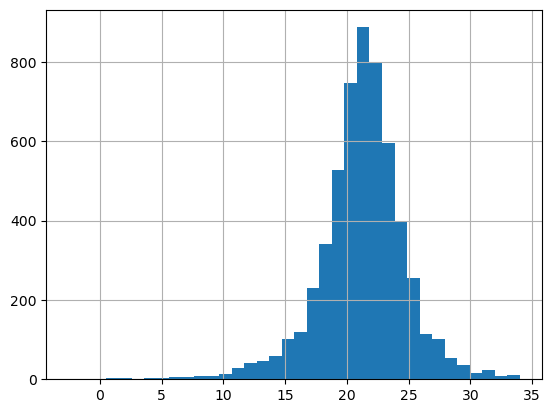

In [144]:
data.IOL_dpt.hist(bins=36)

Check for weirdly high IOL dpt numbers. they are probably typos by the clinic. just two cases - remove those (see more above)

the negative values seem to be okay. it is counterintuitive, as most lenses have around 21dpt, but some lenses hgave a different design and are placed in a slightly different eye location - leading to different refractive nessecitities

In [ ]:
x = data.sort_values("IOL_dpt", ascending=False)
x

#### SE

In [146]:
data.se.describe()

count    5588.000000
mean       -0.323679
std         0.622077
min        -5.312500
25%        -0.666667
50%        -0.300000
75%         0.062500
max         4.166667
Name: se, dtype: float64

<Axes: >

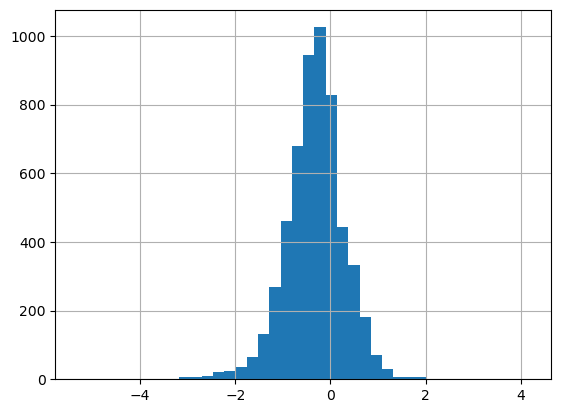

In [147]:
data.se.hist(bins=40)

<Axes: >

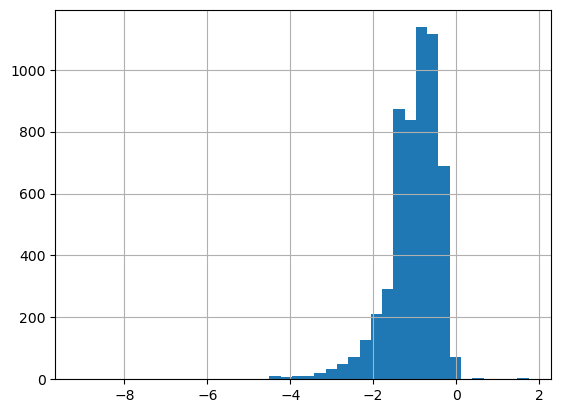

In [148]:
data.cyl.hist(bins=40)

In [ ]:
x = data.sort_values("se", ascending=True)
x

there are also abnormaly high numbers, which seem to by PDF-misreads, and need correction. Update: found a cleaning mistake. now its better

#### Other variables

<Axes: >

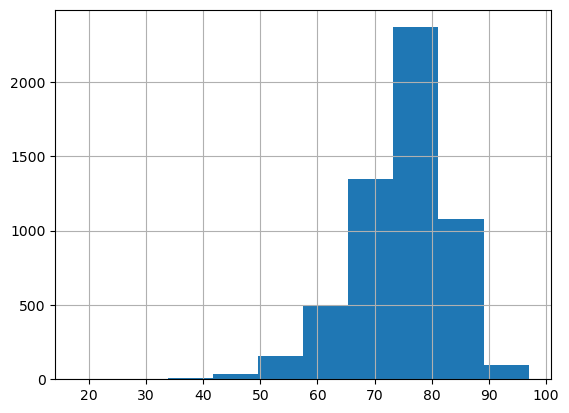

In [150]:
data.age.hist()

<Axes: >

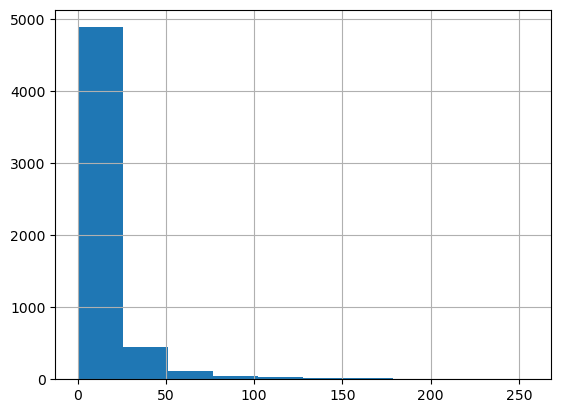

In [151]:
data.weeks_before_surgery.hist()

<Axes: >

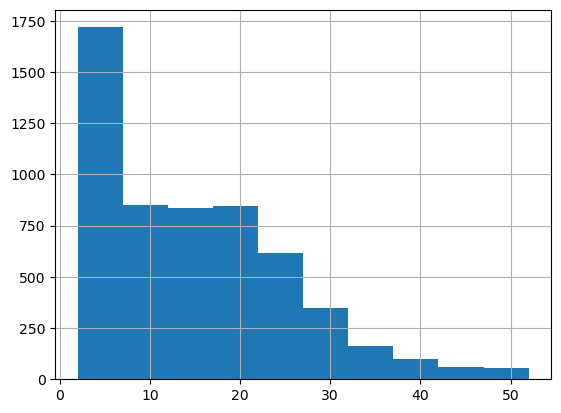

In [152]:
data.weeks_since_surgery.hist()

In [153]:
data.RA_aim.value_counts()

RA_aim
0.0    5589
Name: count, dtype: int64

In [ ]:
data

In [155]:
data.lens_series.value_counts().head(30)

lens_series
Domilens 677                   2292
1stQ                           1119
MBI SAL 302A                    827
Zeiss AT Torbi                  400
Teleon Oculentis 313            181
Zeiss Asphina                   109
Alcon SN6AT                      97
Alcon Clareon                    93
Domilens Nexload-System SZ1      89
Bausch & Lomb Envista            84
Domilens AS66-Y                  69
Alcon SN 60 WF                   43
BunnyLens AF Easy                27
Zeiss CT Lucia 621 P/PY          25
Alcon Vivity                     22
Polytech Domilens Y50P           18
Teleon Acunex AN6V                8
Domilens 877 FABY                 6
Alcon MN60AC                      6
B&L Envista                       6
Eyhance ICB00                     3
Polytech Domilens Orizon          3
Teleon Acunex AN6VT1              3
Zeiss ATLISA TRI toric            3
Orizon                            3
Johnson-Johnson Model ICB00       2
Teleon Acunex W-60R               2
Artis           

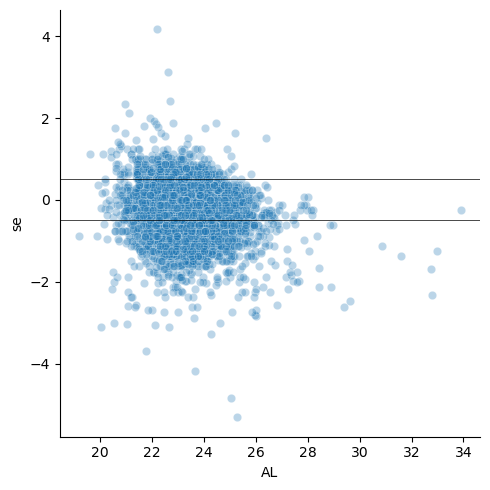

In [156]:
g = sns.relplot(data, x="AL", y="se", alpha=0.3)
g.map(plt.axhline, y=0.5, color='black', linewidth=0.5)  # Dashed blue line at y=0.5
g.map(plt.axhline, y=-0.5, color='black', linewidth=0.5)  # Dashed red line at y=-0.5

In [ ]:
# check high and low AL
z = data.loc[(data["AL"] < 15) | (data["AL"] > 30)]
z

In [ ]:
# -> follow up: loW AL in patnr 1109111 on left side is a missread. delete this case
z = iol_merge.loc[iol_merge.patnr == 1121438] 
z



# 8. Prepare for ML

- remove NA rows in outcome (IOL_dpt) and AL
- drop unneeded columns
- drop information about toric lenses - it does not matter for the minimal model 
- ~~drop SD and @ information, as there are too many NAs and it probably doesnt influence the result.~~ First try including those

In [159]:
# remove NA rows n=16
data = data.dropna(subset=["IOL_dpt"])

# remove NA rows for AL (n=2) - necessary for dummy construction
data = data.dropna(subset=["AL"])

In [160]:
# reduce information of surgery type to Phakoemulsifikation (Phako) vs femtolaserassistierte Kataraktchirurgie (FLACS)
data["proc_short"] = np.where(
    data["procedure"].str.contains("femto", case=False),
    "FLACS",
    np.where(data["procedure"].str.contains("phako", case=False), "Phako", "Other"),
)
 
# validate str search
data.procedure.str.contains("femto", case=False).sum()+ data.procedure.str.contains("phako", case=False).sum() == len(data.procedure)

True

In [161]:
# drop unnneded columns
data_ML = data.drop(
    [
        "patnr",
        "side",
        "surg_date",
        "surg_note_1",
        "surg_note_2",
        "lens_cat",
        "lens_cat_surg",
        "lens",
        "weeks_before_surgery",
        "weeks_since_surgery",
        "birthdate",
        "RA_meas_count",
        "RA_aim",
        "procedure"
    ],
    axis=True,
)
data_ML

,lens_series,sphere,cyl,ax,se,IOL_torisch_dpt,IOL_dpt,AL,VKT,LD,...,R2_at,DeltaD_at,WZW,refr,A0,A1,A2,sex,age,proc_short
0,MBI SAL 302A,0.000,-0.750,NaN,-0.3750,NaN,17.5,24.96,3.010,4.700,...,81.0,171.0,12.00,0.00,-0.701,0.119,0.222,2,60,Phako
1,Zeiss AT Torbi,0.250,-0.750,NaN,-0.1250,1.0,21.0,23.06,2.970,4.640,...,87.0,177.0,12.10,0.30,1.130,0.400,0.100,2,74,Phako
2,Domilens 677,0.750,-1.000,NaN,0.2500,NaN,21.0,23.29,2.600,5.150,...,171.0,NaN,11.90,0.02,0.190,0.192,0.173,2,85,Phako
3,Domilens 677,1.250,-1.500,NaN,0.5000,NaN,22.5,23.70,3.115,4.665,...,95.5,175.0,12.65,-0.03,0.190,0.192,0.173,1,80,Phako
4,Domilens 677,0.625,-1.125,75.0,0.0625,NaN,21.0,22.79,2.910,5.180,...,170.0,80.0,12.10,NaN,NaN,NaN,NaN,1,77,Phako
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5603,Domilens 677,0.500,-1.000,NaN,0.0000,NaN,19.5,24.24,2.980,5.210,...,175.0,NaN,12.30,-0.01,0.190,0.192,0.173,1,86,Phako
5604,Bausch & Lomb Envista,0.250,-0.750,126.0,-0.1250,NaN,21.5,23.38,3.070,4.600,...,111.0,NaN,12.20,0.11,0.183,0.315,0.172,2,72,Phako
5605,Bausch & Lomb Envista,0.500,-0.750,87.0,0.1250,NaN,22.0,22.79,2.420,5.020,...,70.5,160.5,11.65,-0.31,0.183,0.315,0.172,1,66,FLACS
5606,Domilens 677,-1.000,-0.500,NaN,-1.2500,NaN,22.5,22.93,2.990,4.910,...,151.0,NaN,11.80,-0.17,0.190,0.192,0.173,1,70,Phako


In [162]:
# save data_ML to csv for model building
data_ML.to_csv('data/data_ML_mvm_v1.csv', index=False)

# Validate Individual Cases

In [ ]:
data.loc[data.se> 1.5,["patnr", "surg_date", "side", "lens", "RA_aim", "sphere", "se", "sex"]]

In [ ]:
id = 123456
refr.loc[refr.patnr == id]

In [ ]:
iol_merge.loc[iol_merge.patnr == id, "filename"].values[0]